Install libraries

In [3]:
!pip install ctgan
!pip install table_evaluator
!pip install sdv


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import pandas as pd
import numpy as np

In [25]:
from sdv.evaluation import evaluate

In [17]:
# from ctgan import CTGAN
from ctgan import CTGANSynthesizer
ctgan = CTGANSynthesizer()

Read in and store dataset in data variable

In [19]:
data = pd.read_csv('../exploratory_data/cov_features_no.csv')

Create unique IDs for hashed phone number

In [20]:
import hashlib

# Define a hash function to generate a unique integer for each hash value
def hash_to_integer(hash_value):
    hash_to_int = {}
    if hash_value not in hash_to_int:
        # Hash the value using SHA-256 algorithm and convert it to an integer
        hash_bytes = bytes(hash_value, 'utf-8')
        hashed = int.from_bytes(hashlib.sha256(hash_bytes).digest(), byteorder='big')
        # Map the hashed value to a unique integer in the desired range
        unique_int = hashed % (10 ** 12 - 10 ** 10 + 1) + 10 ** 10
        hash_to_int[hash_value] = unique_int
    return hash_to_int[hash_value]

# Map the hash column to a column of unique numbers
data['phone_no_nunique'] = data['phone_no_m'].apply(hash_to_integer)



In [21]:
data.columns

Index(['duration', 'phone_no_m', 'label', 'hour', 'day', 'month', 'year',
       'weekday', 'weekend', 'peak', 'offpeak', 'dur_under_6', 'col_0',
       'col_1', 'col_2', 'col_3', 'phone_no_nunique'],
      dtype='object')

Drop columns not needed by the GAN

In [22]:
data = data.drop(['phone_no_m'],1)

/tmp/ipykernel_83/413985680.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(['phone_no_m'],1)


In [23]:
data

,duration,label,hour,day,month,year,weekday,weekend,peak,offpeak,dur_under_6,col_0,col_1,col_2,col_3,phone_no_nunique
0,2,1,16,2,5,2021,1,0,1,0,1,0,0,0,1,138943362620
1,0,1,13,2,5,2021,1,0,1,0,1,0,0,0,1,138943362620
2,0,1,13,2,5,2021,1,0,1,0,1,0,0,0,1,138943362620
3,0,1,12,2,5,2021,1,0,1,0,1,0,0,0,1,138943362620
4,0,1,11,2,5,2021,1,0,1,0,1,0,0,0,1,138943362620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582048,95,0,18,0,11,2021,1,0,0,0,0,0,0,0,1,657505672913
582049,70,0,18,0,11,2021,1,0,0,0,0,0,0,0,1,657505672913
582050,98,0,19,0,11,2021,1,0,0,1,0,0,0,0,1,657505672913
582051,301,0,21,0,11,2021,1,0,0,1,0,0,0,0,1,657505672913


Store only fraud calls in the abnorm variable

In [24]:
abnorm = data[data['label'] == 1]

# abnorm = abnorm[:30000]

Build model by calling ctgansynthesizer

In [26]:
model = CTGANSynthesizer(
        epochs=500,
        batch_size=150,
        generator_dim=(16, 7, 15),
        discriminator_dim=(16, 7, 1)
        )

Train data

In [ ]:
model.fit(abnorm, abnorm.columns.values)
model.save("results/manual-CTGAN.pkl")

Generate fraud data samples; set size to 2,000,000 for sichuan data

In [26]:
new_data = model.sample(40000)

In [22]:
new_data

,duration,label,hour,day,month,year,weekday,weekend,peak,offpeak,dur_under_6,col_0,col_1,col_2,col_3
0,0,1,20,0,10,2021,1,1,0,1,1,0,0,0,1
1,0,1,5,3,6,2020,1,0,1,0,1,0,0,0,1
2,0,1,13,3,6,2021,1,0,1,0,1,0,0,0,1
3,125,1,14,4,4,2018,1,0,1,0,1,0,0,0,1
4,0,1,6,5,4,2019,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,1,17,3,11,2021,0,0,1,0,1,1,0,0,0
19996,0,1,16,3,7,2018,1,0,1,0,0,0,0,0,1
19997,0,1,13,0,4,2021,1,0,0,0,1,1,0,0,1
19998,5,1,15,5,3,2019,0,0,1,0,1,0,0,0,1


Evaluate result (>90% desired)

In [27]:
evaluate(new_data, abnorm)
# 0.97329

0.9546758959097088

Visualise similarity scores nd evaluation result of synthetic data and real data

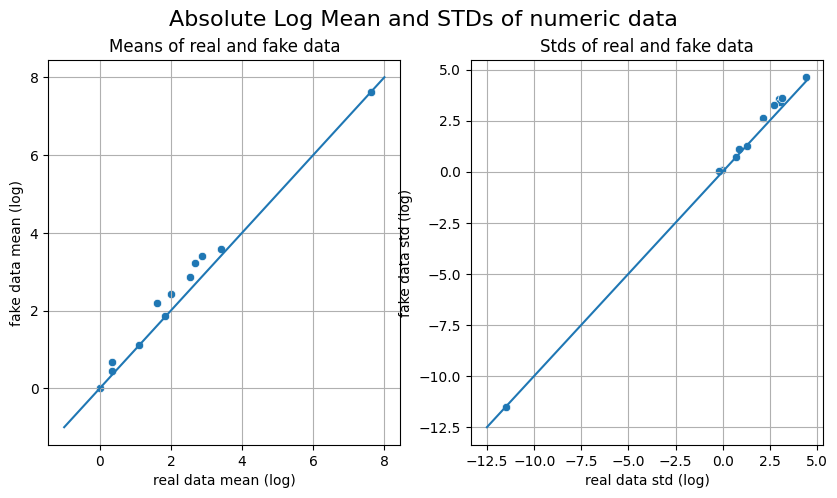

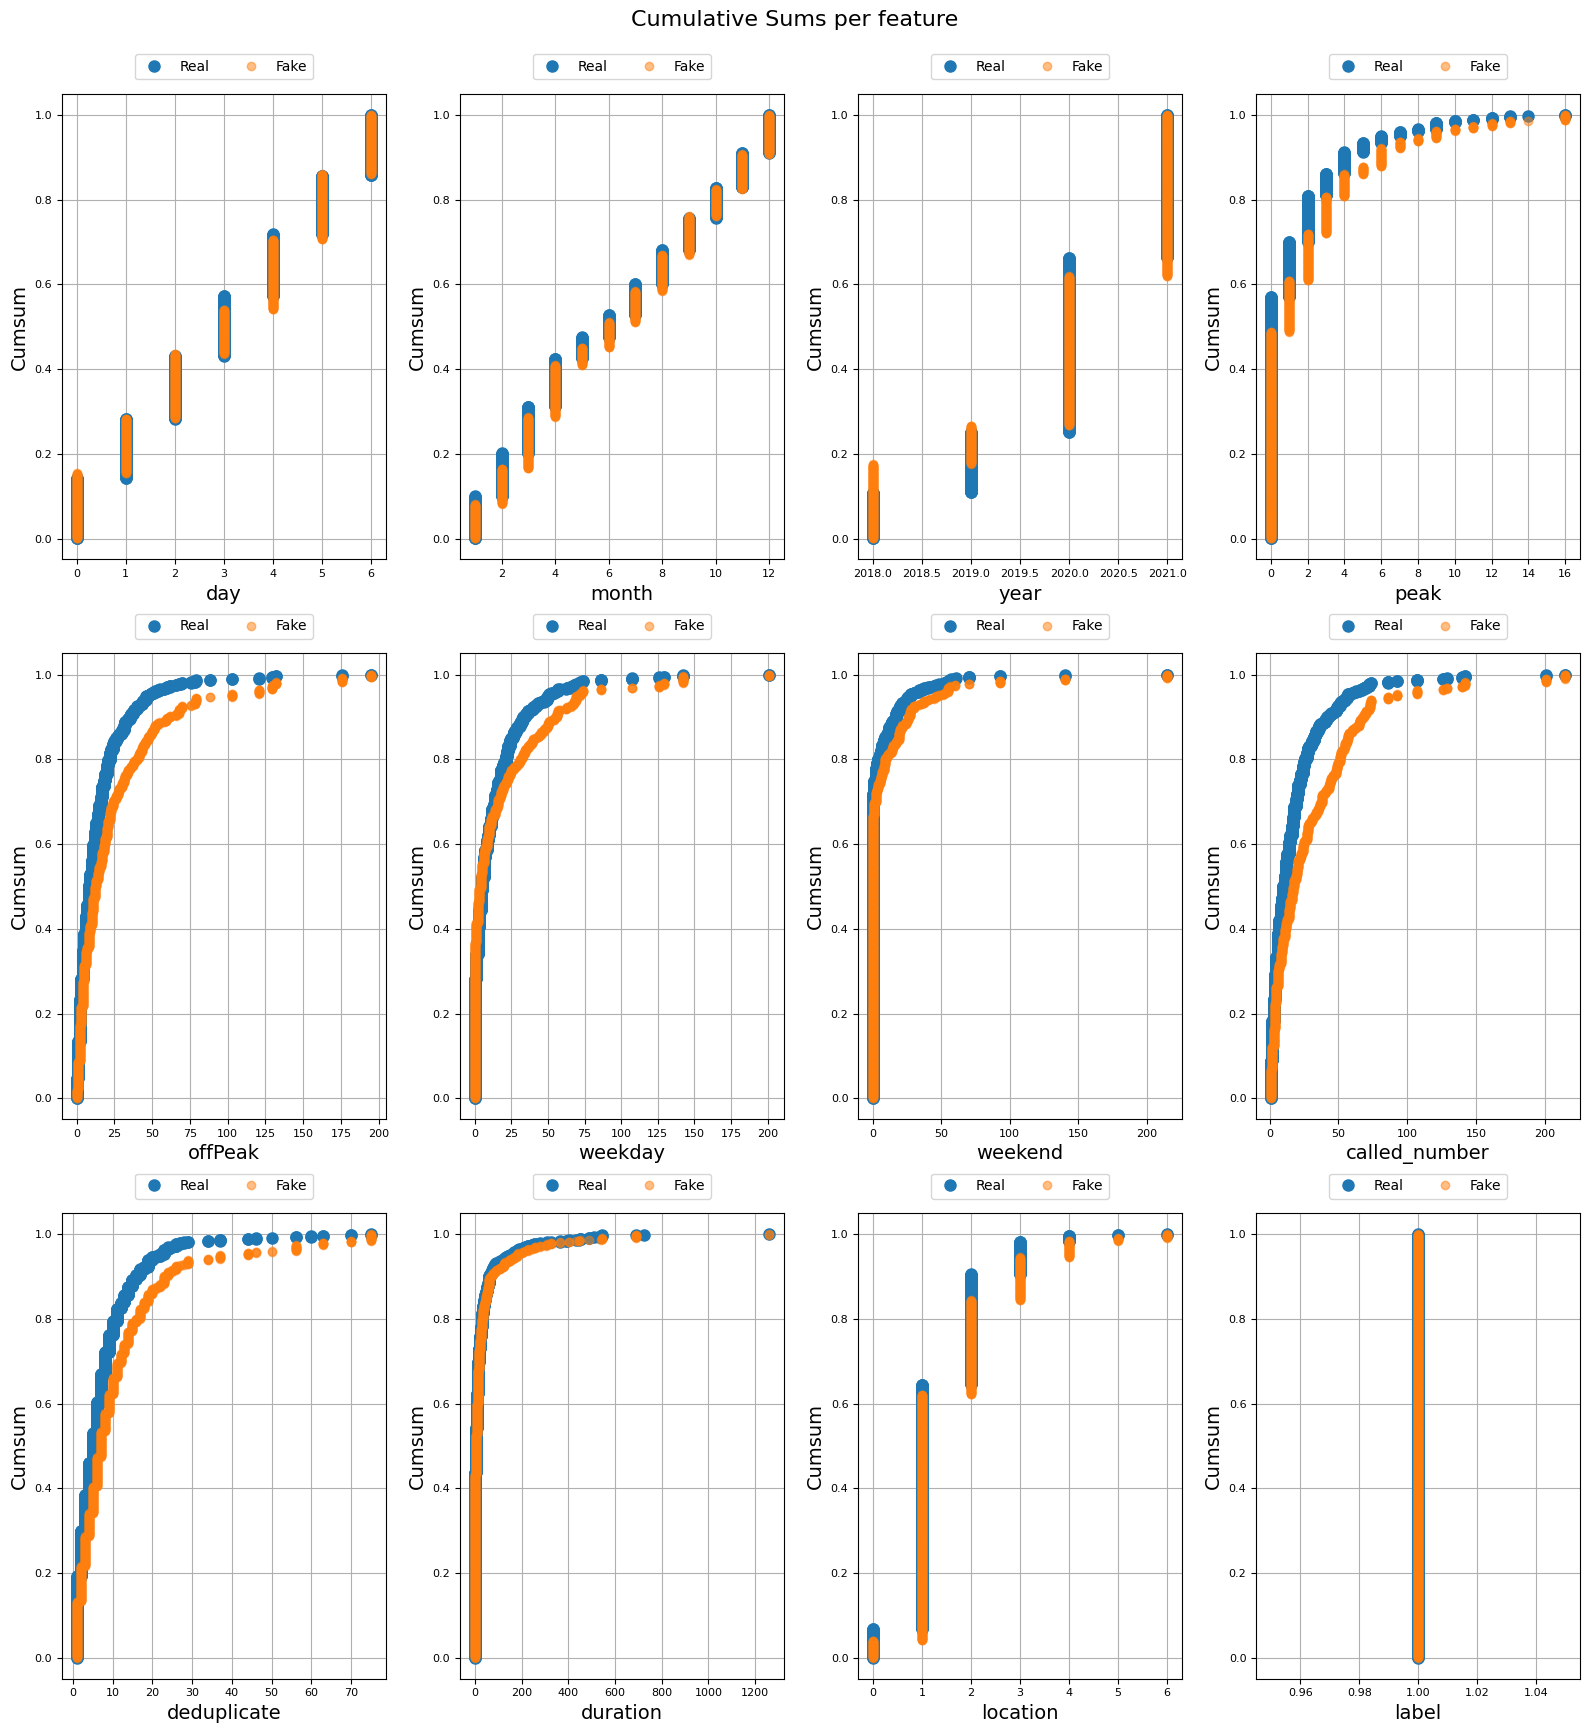

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


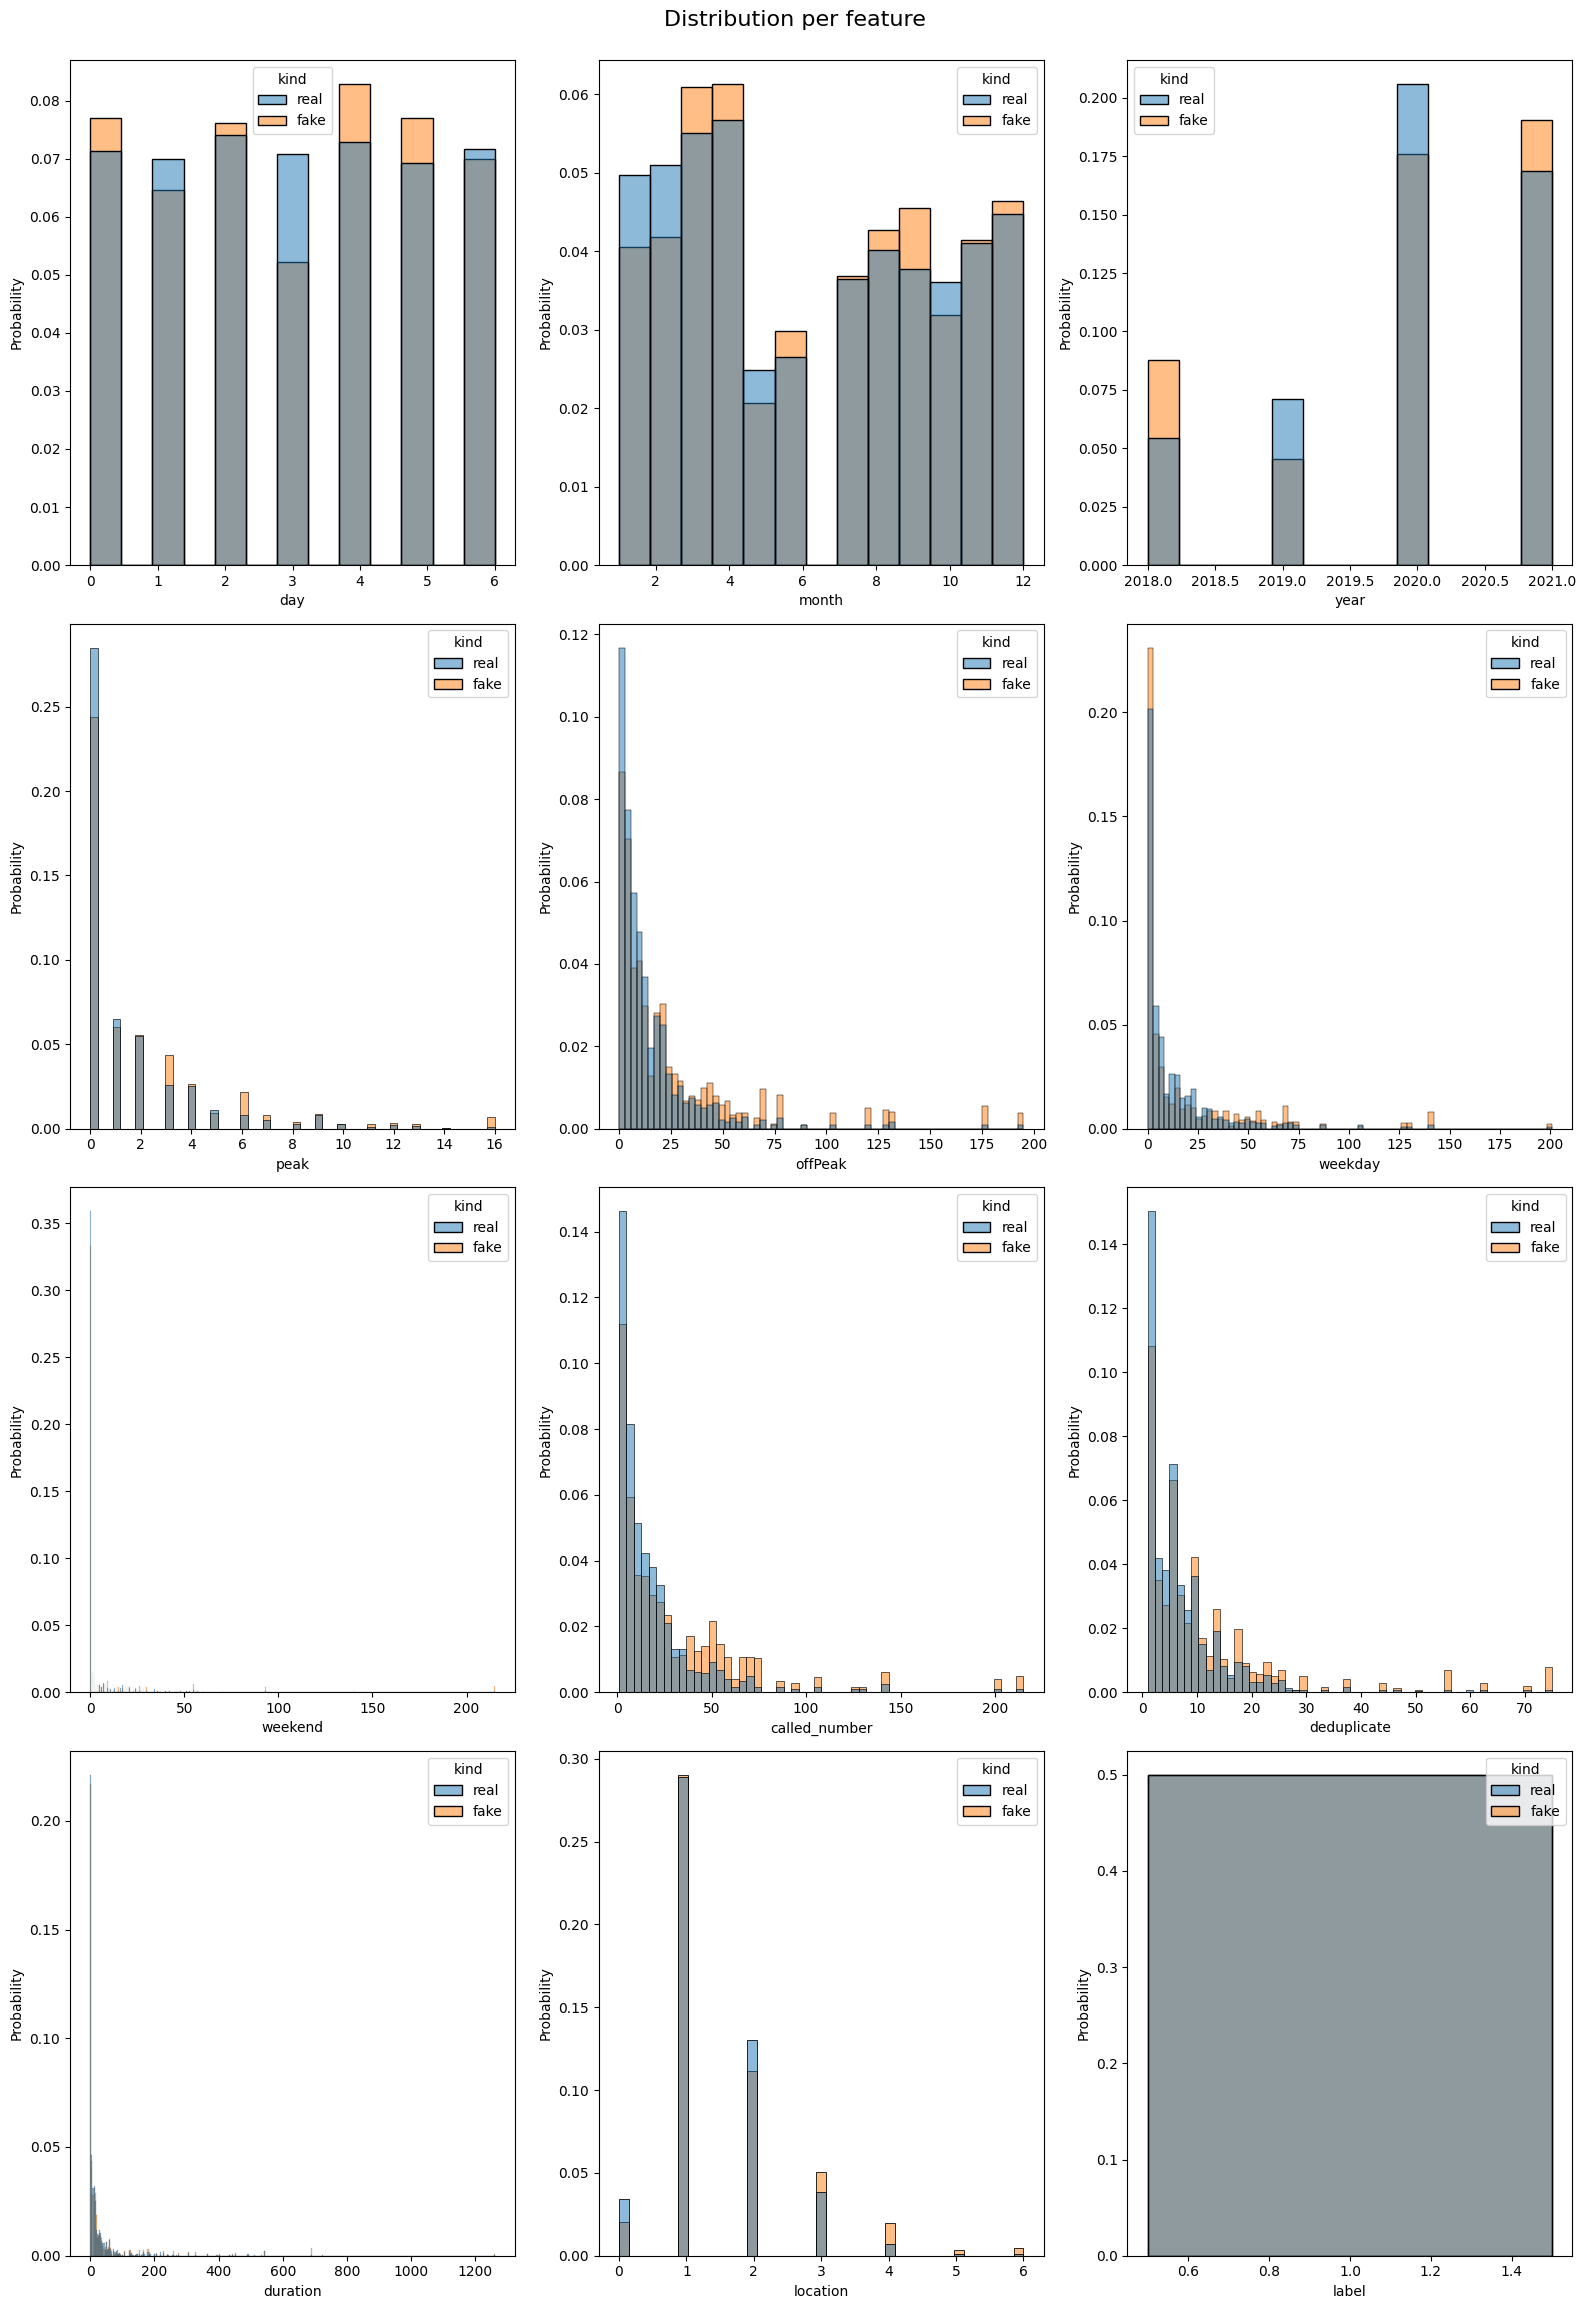

TypeError: Image data of dtype object cannot be converted to float

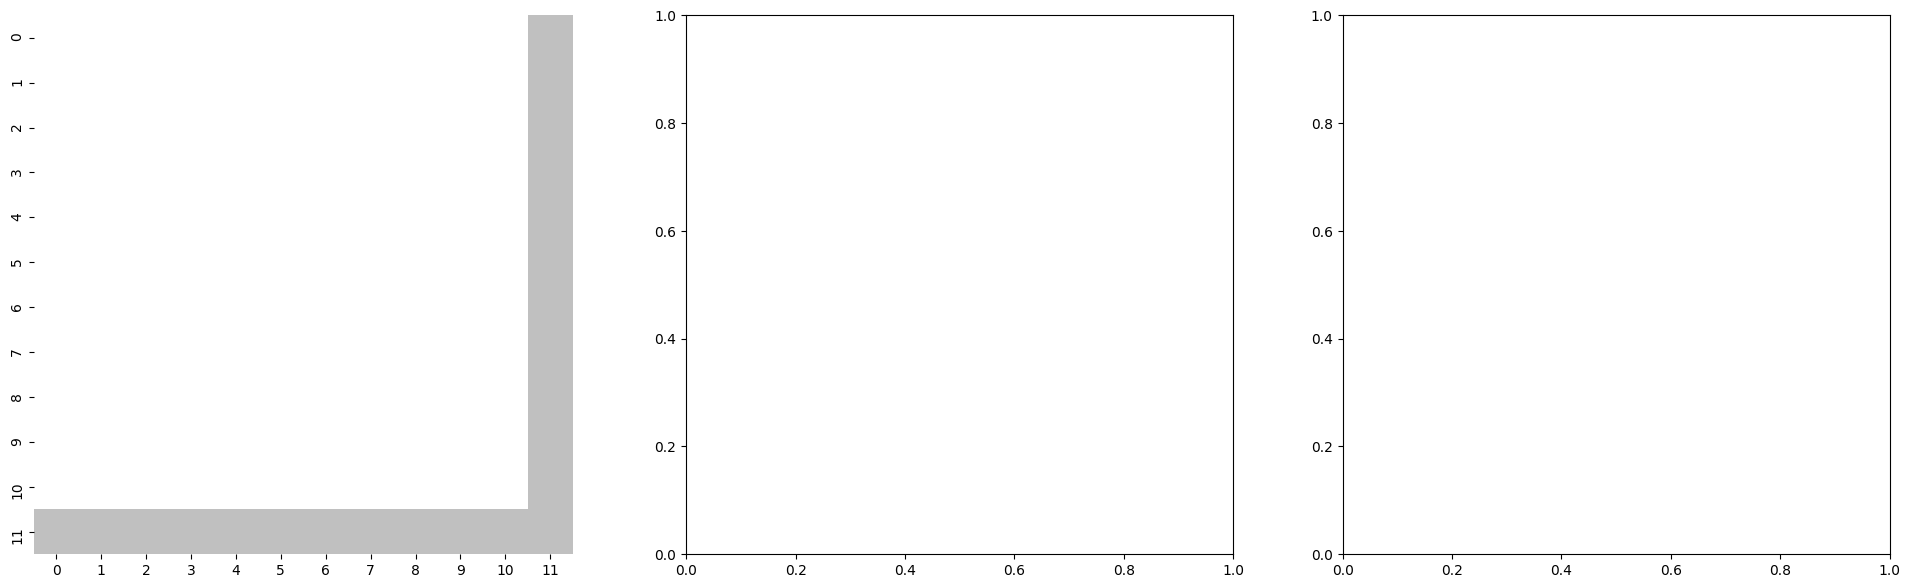

In [69]:
from table_evaluator import load_data, TableEvaluator

table_evaluator = TableEvaluator(abnorm, new_data)
# table_evaluator.evaluate(target_col='label')
table_evaluator.visual_evaluation()

In [28]:
new_data.to_csv('cov_synth_new')

In [ ]:
import seaborn as sns

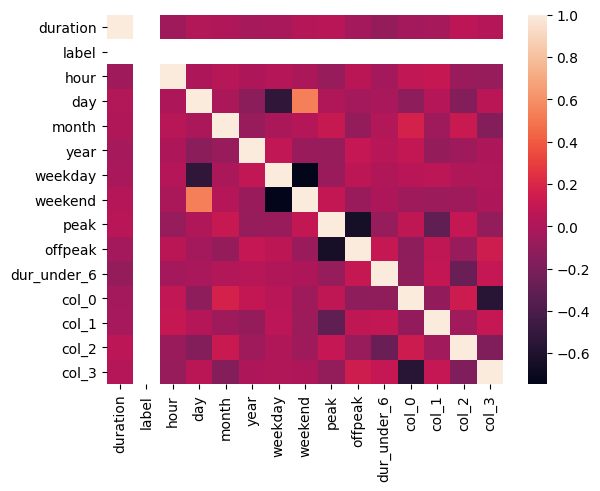

In [31]:
sns.heatmap(new_data.corr());

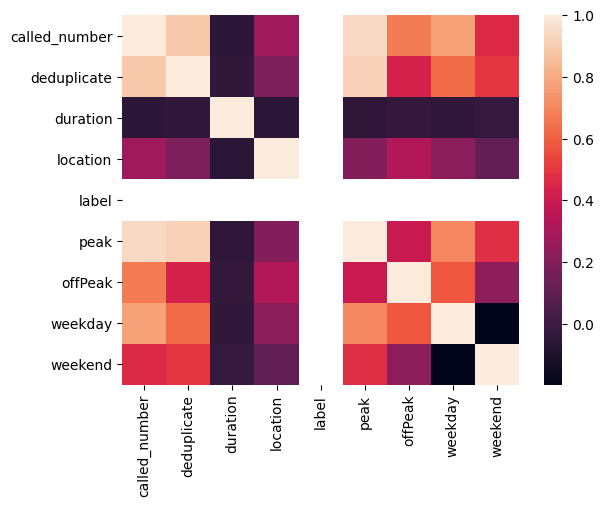

In [46]:
sns.heatmap(abnorm.corr());